In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
PoreBounds = [ 3000, 1194, 475, 189, 75, 30, 8.6, 2.47, 0.707, 0.202, 0.0005 ]

BoundPSI =  np.divide(-3000,PoreBounds)

In [3]:
def ThetaCurve(SAT,DUL,LL15,PSI):

    ##Set up parameters for spline
    psid = -100
    psi0 = -0.6e7
    psi_ll15 = -15000.0;

    DELk = [0] * 4
    DELk[0] = (DUL - (SAT+0.000000000001)) / (np.log10(-psid))#Tiny amount added to Sat so in situations where DUL = SAT this function returns a non zero value
    DELk[1] = (LL15 - DUL) / (np.log10(-psi_ll15) - np.log10(-psid))
    DELk[2] = -LL15 / (np.log10(-psi0) - np.log10(-psi_ll15))
    DELk[3] = -LL15 / (np.log10(-psi0) - np.log10(-psi_ll15))

    Mk = [0] * 4
    Mk[0] = 0.0
    Mk[1] = (DELk[0] + DELk[1]) / 2.0
    Mk[2] = (DELk[1] + DELk[2]) / 2.0
    Mk[3] = DELk[3]

    # First bit might not be monotonic so check and adjust
    alpha = Mk[0] / DELk[0]
    beta = Mk[1] / DELk[0]
    phi = alpha - (np.power(2.0 * alpha + beta - 3.0, 2.0) / (3.0 * (alpha + beta - 2.0)));
    if (phi <= 0):
        tau = 3.0 / np.sqrt(alpha * alpha + beta * beta)
        Mk[0] = tau * alpha * DELk[0]
        Mk[1] = tau * beta * DELk[0]

    M0 = [0] * 5
    M1 = [0] * 5
    Y0 = [0] * 5
    Y1 = [0] * 5

    M0[0] = 0.0;
    M1[0] = 0.0;
    Y0[0] = SAT;
    Y1[0] = SAT;

    M0[1] = Mk[0] * (np.log10(-psid) - 0.0);
    M1[1] = Mk[1] * (np.log10(-psid) - 0.0);
    Y0[1] = SAT;
    Y1[1] = DUL;

    M0[2] = Mk[1] * (np.log10(-psi_ll15) - np.log10(-psid));
    M1[2] = Mk[2] * (np.log10(-psi_ll15) - np.log10(-psid));
    Y0[2] = DUL;
    Y1[2] = LL15;

    M0[3] = Mk[2] * (np.log10(-psi0) - np.log10(-psi_ll15));
    M1[3] = Mk[3] * (np.log10(-psi0) - np.log10(-psi_ll15));
    Y0[3] = LL15;
    Y1[3] = 0.0;

    M0[4] = 0.0;
    M1[4] = 0.0;
    Y0[4] = 0.0;
    Y1[4] = 0.0;

    Thetas = []
    Test = []
    for psi in PSI:
        if (psi >= -1.0):
            i = 0;
            t = 0.0;
        elif (psi > psid):
            i = 1;
            t = (np.log10(-psi) - 0.0) / (np.log10(-psid) - 0.0);
        elif (psi > psi_ll15):
            i = 2;
            t = (np.log10(-psi) - np.log10(-psid)) / (np.log10(-psi_ll15) - np.log10(-psid));
        elif (psi > psi0):
            i = 3;
            t = (np.log10(-psi) - np.log10(-psi_ll15)) / (np.log10(-psi0) - np.log10(-psi_ll15));
        else:
            i = 4;
            t = 0.0;

        tSqr = t * t;
        tCube = tSqr * t;
        theta = (2 * tCube - 3 * tSqr + 1) * Y0[i] + (tCube - 2 * tSqr + t) * M0[i]\
                + (-2 * tCube + 3 * tSqr) * Y1[i] + (tCube - tSqr) * M1[i];
        Thetas.append(min(theta, SAT))#When Sat and DUL are very close, spline can produce number greater that sat
    return Thetas

In [4]:
BoundrySuction = [0,0,0.4,0.4,0.8,0.8,1.2,1.2,1.6,1.6,2,2,2.54,2.54,3.085,3.085,3.6275,3.6275,4.17,4.17,6.77,6.77]
BoundryMarkers = [-0.1,10000,10000,-0.1,-0.1,10000,10000,-0.1,-0.1,10000,10000,-0.1,-0.1,10000,10000,-0.1,-0.1,10000,10000,-0.1,-0.1,10000]

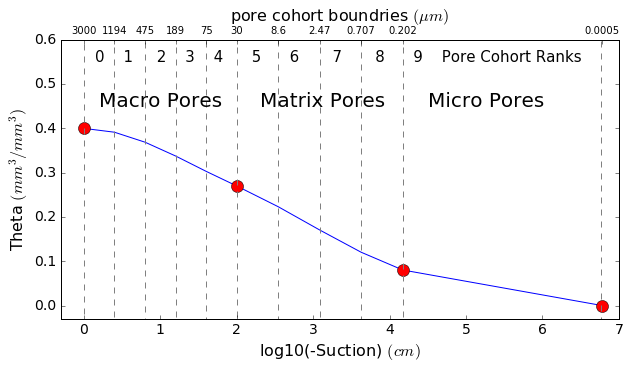

In [5]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(np.log10(-BoundPSI),ThetaCurve(0.4,0.27,0.08,BoundPSI))
ax1.plot(np.log10([ 1.0, 100.0, 14851, 6000000]),[0.40,0.27,0.08,0],'o',color = 'red',markersize=12)
ax1.plot(BoundrySuction,BoundryMarkers,'--',color='grey')
ax1.set_xlim(-.30,7)
ax1.set_ylim(-.03,.6)
ax1.set_xlabel(r'log10(-Suction) $(cm)$',fontsize=16)
ax1.set_ylabel(r'Theta $(mm^3/mm^3)$',fontsize=16)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.log10(-BoundPSI))
ax2.set_xticklabels(PoreBounds)
ax2.set_xlabel(r'pore cohort boundries $(\mu m)$',fontsize=16)
ax1.tick_params(labelsize = 14)
plt.text(0.2,.45,'Macro Pores',fontsize=20)
plt.text(2.3,.45,'Matrix Pores',fontsize=20)
plt.text(4.5,.45,'Micro Pores',fontsize=20)
plt.text(0.15,.55,'0    1     2    3    4      5      6       7       8      9    Pore Cohort Ranks',fontsize=15)

In [18]:
def MakeConductivityFrame(SAT,DUL,LL15):
    # DiaUpper Units = um
    ConductivityFrame = pd.DataFrame(index = range(11), columns = ['DiaUpper'], data = PoreBounds)
    # DiaLower Units = um
    for x in ConductivityFrame.index:
        try:
            ConductivityFrame.ix[x,'DiaLower'] = ConductivityFrame.ix[x+1,'DiaUpper']
        except:
            ConductivityFrame.ix[x,'DiaLower'] = 0
    # PsiUpper units = cmH2O
    ConductivityFrame.ix[:,'PsiUpper'] = np.divide(-3000,ConductivityFrame.ix[:'DiaUpper']) 
    # PsiLower units = cmH2O
    for x in ConductivityFrame.index:
        try:
            ConductivityFrame.ix[x,'PsiLower'] = ConductivityFrame.ix[x+1,'PsiUpper']
        except:
            ConductivityFrame.ix[x,'PsiLower'] = 0
    # ThetaUpper Units = mm3/mm3
    ConductivityFrame.ix[:,'ThetaUpper'] = ThetaCurve(SAT,DUL,LL15,ConductivityFrame.ix[:,'PsiUpper'])
    # ThetaLower Units = mm3/mm3
    ConductivityFrame.ix[:,'ThetaLower'] = ThetaCurve(SAT,DUL,LL15,ConductivityFrame.ix[:,'PsiLower'])  
    # Volume Units = mm3/mm3
    ConductivityFrame.ix[:,'Volume'] = ConductivityFrame.ix[:,'ThetaUpper'] - ConductivityFrame.ix[:,'ThetaLower']
    # Radius units = um
    ConductivityFrame.ix[:,'Radius'] = (ConductivityFrame.ix[:,'DiaUpper'] + ConductivityFrame.ix[:,'DiaLower'])/4 
    # Area units = um2
    ConductivityFrame.ix[:,'Area'] = np.pi * np.power(ConductivityFrame.ix[:,'Radius'],2)
    # Number units = /m
    ConductivityFrame.ix[:,'Number'] = ConductivityFrame.ix[:,'Volume']/(ConductivityFrame.ix[:,'Area']/1000000000000)
    # Xflow is unitless
    ConductivityFrame.ix[:,'Xflow'] = 1.6 + 2 * np.exp(ConductivityFrame.ix[:,'Radius']*-0.008)
    # PoreFlowRate units = cm3/s
    ConductivityFrame.ix[:,'PoreFlowRate'] = 0.0005 * np.power((ConductivityFrame.ix[:,'Radius']/10000),ConductivityFrame.ix[:,'Xflow'])
    # VolumetricFlowRate units = cm3/s/m2
    ConductivityFrame.ix[:,'VolumetricFlowRate'] = ConductivityFrame.ix[:,'PoreFlowRate'] * ConductivityFrame.ix[:,'Number']
    # Capilalarity units = mm/h
    ConductivityFrame.ix[:,'Capillarity'] = ConductivityFrame.ix[:,'VolumetricFlowRate']/1000*3600
    ConductivityFrame.ix[:,'Sorbtivity'] = np.sqrt(((7.4/ConductivityFrame.ix[:,'Radius']*1000) * ConductivityFrame.ix[:,'Capillarity'])/0.5)
    ConductivityFrame.ix[:,'Sorption'] = 0.5 * ConductivityFrame.ix[:,'Sorbtivity'] * np.power(1,-0.5)  
    ConductivityFrame.ix[:,'Kin'] = ConductivityFrame.ix[:,'Capillarity'] + ConductivityFrame.ix[:,'Sorption'] 
    ConductivityFrame.ix[:,'CumCapil'] = 0
    for x in reversed(ConductivityFrame.index):
        if x < 10:
            ConductivityFrame.ix[x,'CumCapil'] = ConductivityFrame.ix[x+1,'CumCapil'] + ConductivityFrame.ix[x,'Capillarity']
    ConductivityFrame.ix[:,'CumSorp'] = 0
    for x in reversed(ConductivityFrame.index):
        if x < 10:
            ConductivityFrame.ix[x,'CumSorp'] = ConductivityFrame.ix[x+1,'CumSorp'] + ConductivityFrame.ix[x,'Sorbtivity']
    ConductivityFrame.ix[:,'Cumkin'] = ConductivityFrame.ix[:,'CumCapil'] + ConductivityFrame.ix[:,'CumSorp']
    return ConductivityFrame

In [20]:
SAT = 0.40
DUL = 0.27
LL15 = 0.08
TestFrame = MakeConductivityFrame(SAT,DUL,LL15)
TestFrame

,DiaUpper,DiaLower,PsiUpper,PsiLower,ThetaUpper,ThetaLower,Volume,Radius,Area,Number,Xflow,PoreFlowRate,VolumetricFlowRate,Capillarity,Sorbtivity,Sorption,Kin,CumCapil,CumSorp,Cumkin
0,3000.0000,1194.0000,-1.000000e+00,-2.512563e+00,0.400000,0.391349,0.008651,1048.500000,3.453717e+06,2.504781e+03,1.600455,1.353423e-05,3.390029e-02,1.220410e-01,1.312501,0.656250,0.778291,5.979290e-01,9.482394,10.080323
1,1194.0000,475.0000,-2.512563e+00,-6.315789e+00,0.391349,0.368832,0.022517,417.250000,5.469436e+05,4.116842e+04,1.671016,2.475315e-06,1.019048e-01,3.668573e-01,3.607292,1.803646,2.170503,4.758880e-01,8.169893,8.645781
2,475.0000,189.0000,-6.315789e+00,-1.587302e+01,0.368832,0.337637,0.031195,166.000000,8.656973e+04,3.603464e+05,2.130013,8.086791e-08,2.914046e-02,1.049057e-01,3.058273,1.529137,1.634042,1.090307e-01,4.562601,4.671632
3,189.0000,75.0000,-1.587302e+01,-4.000000e+01,0.337637,0.302837,0.034800,66.000000,1.368478e+04,2.542973e+06,2.779567,4.347573e-10,1.105576e-03,3.980074e-03,0.944723,0.472361,0.476342,4.125003e-03,1.504328,1.508453
4,75.0000,30.0000,-4.000000e+01,-1.000000e+02,0.302837,0.270000,0.032837,26.250000,2.164754e+03,1.516906e+07,3.221168,2.429689e-12,3.685609e-05,1.326819e-04,0.273509,0.136755,0.136887,1.449285e-04,0.559605,0.559750
5,30.0000,8.6000,-1.000000e+02,-3.488372e+02,0.270000,0.223161,0.046839,9.650000,2.925530e+02,1.601059e+08,3.451409,1.955867e-14,3.131458e-06,1.127325e-05,0.131490,0.065745,0.065756,1.224651e-05,0.286095,0.286108
6,8.6000,2.4700,-3.488372e+02,-1.214575e+03,0.223161,0.170693,0.052468,2.767500,2.406163e+01,2.180546e+09,3.556207,1.112496e-16,2.425850e-07,8.733058e-07,0.068339,0.034170,0.034170,9.732623e-07,0.154606,0.154607
7,2.4700,0.7070,-1.214575e+03,-4.243281e+03,0.170693,0.120356,0.050337,0.794250,1.981821e+00,2.539918e+10,3.587332,9.789357e-19,2.486417e-08,8.951100e-08,0.040840,0.020420,0.020420,9.995648e-08,0.086266,0.086267
8,0.7070,0.2020,-4.243281e+03,-1.485149e+04,0.120356,0.080256,0.040101,0.227250,1.622399e-01,2.471696e+11,3.596367,9.982801e-21,2.467445e-09,8.882801e-09,0.024052,0.012026,0.012026,1.044548e-08,0.045426,0.045426
9,0.2020,0.0005,-1.485149e+04,-6.000000e+06,0.080256,0.000000,0.080256,0.050625,8.051558e-03,9.967718e+12,3.599190,4.354845e-23,4.340787e-10,1.562683e-09,0.021374,0.010687,0.010687,1.562683e-09,0.021374,0.021374


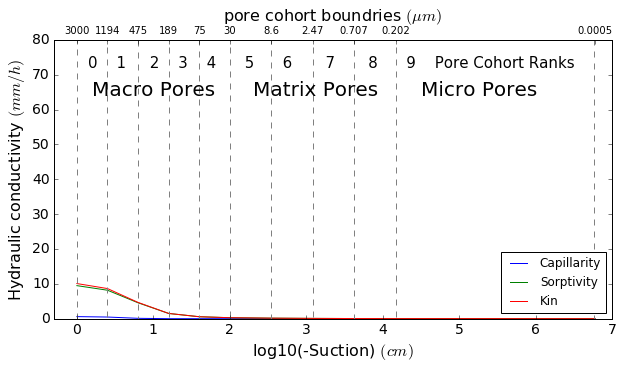

In [21]:
ymax = 80
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(np.log10(-TestFrame.ix[:,'PsiUpper']),TestFrame.ix[:,'CumCapil'],label = 'Capillarity')
ax1.plot(np.log10(-TestFrame.ix[:,'PsiUpper']),TestFrame.ix[:,'CumSorp'],label = 'Sorptivity')
ax1.plot(np.log10(-TestFrame.ix[:,'PsiUpper']),TestFrame.ix[:,'Cumkin'],label = 'Kin')
ax1.plot(BoundrySuction,BoundryMarkers,'--',color='grey')
ax1.set_xlim(-.30,7)
ax1.set_ylim(-.03,ymax)
ax1.set_xlabel(r'log10(-Suction) $(cm)$',fontsize=16)
ax1.set_ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.log10(-BoundPSI))
ax2.set_xticklabels(PoreBounds)
ax2.set_xlabel(r'pore cohort boundries $(\mu m)$',fontsize=16)
ax1.tick_params(labelsize = 14)
plt.text(0.2,ymax*0.8,'Macro Pores',fontsize=20)
plt.text(2.3,ymax*0.8,'Matrix Pores',fontsize=20)
plt.text(4.5,ymax*0.8,'Micro Pores',fontsize=20)
plt.text(0.15,ymax*0.9,'0    1     2    3    4      5      6       7       8      9    Pore Cohort Ranks',fontsize=15)
ax1.legend(loc=4)

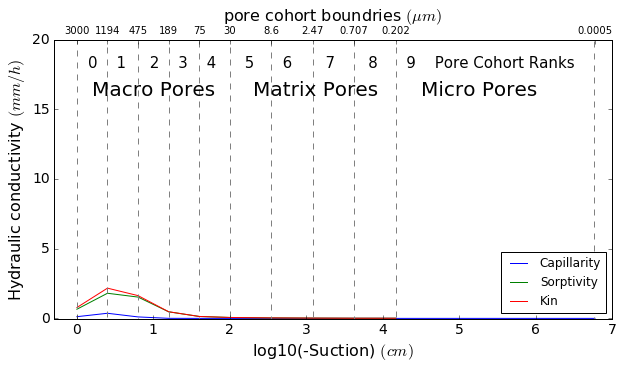

In [22]:
ymax = 20
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(np.log10(-TestFrame.ix[:,'PsiUpper']),TestFrame.ix[:,'Capillarity'],label = 'Capillarity')
ax1.plot(np.log10(-TestFrame.ix[:,'PsiUpper']),TestFrame.ix[:,'Sorption'],label = 'Sorptivity')
ax1.plot(np.log10(-TestFrame.ix[:,'PsiUpper']),TestFrame.ix[:,'Kin'],label = 'Kin')
ax1.plot(BoundrySuction,BoundryMarkers,'--',color='grey')
ax1.set_xlim(-.30,7)
ax1.set_ylim(-.03,ymax)
ax1.set_xlabel(r'log10(-Suction) $(cm)$',fontsize=16)
ax1.set_ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.log10(-BoundPSI))
ax2.set_xticklabels(PoreBounds)
ax2.set_xlabel(r'pore cohort boundries $(\mu m)$',fontsize=16)
ax1.tick_params(labelsize = 14)
plt.text(0.2,ymax*0.8,'Macro Pores',fontsize=20)
plt.text(2.3,ymax*0.8,'Matrix Pores',fontsize=20)
plt.text(4.5,ymax*0.8,'Micro Pores',fontsize=20)
plt.text(0.15,ymax*0.9,'0    1     2    3    4      5      6       7       8      9    Pore Cohort Ranks',fontsize=15)
ax1.legend(loc=4)

In [23]:
Poris = MakeConductivityFrame(0.45,.3,.08)
Intermediate = MakeConductivityFrame(0.38,.3,.08)
Compact = MakeConductivityFrame(0.32,.3,.08)

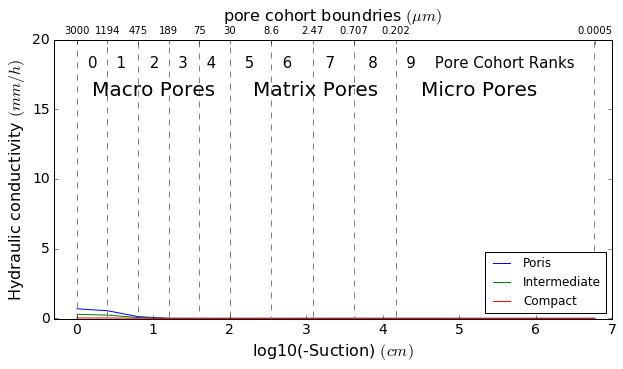

In [24]:
ymax = 20
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(np.log10(-Poris.ix[:,'PsiUpper']),Poris.ix[:,'CumCapil'],label = 'Poris')
ax1.plot(np.log10(-Intermediate.ix[:,'PsiUpper']),Intermediate.ix[:,'CumCapil'],label = 'Intermediate')
ax1.plot(np.log10(-Compact.ix[:,'PsiUpper']),Compact.ix[:,'CumCapil'],label = 'Compact')
ax1.plot(BoundrySuction,BoundryMarkers,'--',color='grey')
ax1.set_xlim(-.30,7)
ax1.set_ylim(-.03,ymax)
ax1.set_xlabel(r'log10(-Suction) $(cm)$',fontsize=16)
ax1.set_ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.log10(-BoundPSI))
ax2.set_xticklabels(PoreBounds)
ax2.set_xlabel(r'pore cohort boundries $(\mu m)$',fontsize=16)
ax1.tick_params(labelsize = 14)
plt.text(0.2,ymax*0.8,'Macro Pores',fontsize=20)
plt.text(2.3,ymax*0.8,'Matrix Pores',fontsize=20)
plt.text(4.5,ymax*0.8,'Micro Pores',fontsize=20)
plt.text(0.15,ymax*0.9,'0    1     2    3    4      5      6       7       8      9    Pore Cohort Ranks',fontsize=15)
ax1.legend(loc=4)

## Bring in some test data

### Conductivity in cm/d

In [12]:
CondData = pd.read_excel('.\Data\lab_drying_h-k.xlsx')
ThetaData = pd.read_excel('.\Data\lab_drying_h-t.xlsx')
MergedData = pd.merge(left=ThetaData, right=CondData,on=['code','preshead'])
Data = MergedData.dropna()
Data.set_index('code',inplace=True,drop=False)
#This cell throws a copy slice error and takes a long time to run, but it still does what is intended.
Data.ix[:,'FullSet'] = 'false'
for soil in Data.index:
    if Data.ix[soil,'preshead'].max() >= 15000 and Data.ix[soil,'preshead'].min() <= 100:
        Data.ix[soil,'FullSet'] = 'true'
        
SetFilter = Data.ix[:,'FullSet'] == 'true'
FullData = Data.ix[SetFilter,:].copy()

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


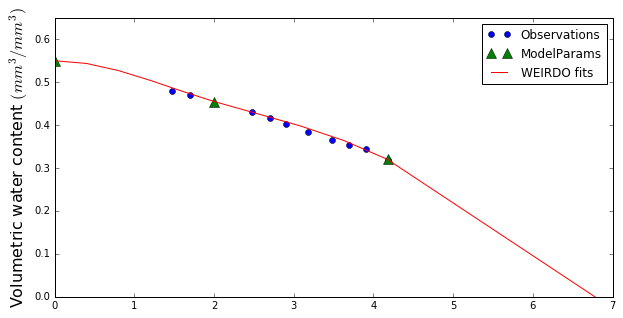

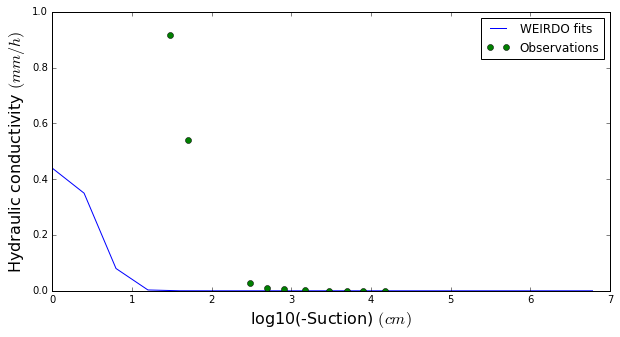

In [26]:
Set = '2360'
FitSAT = 0.55
FitDUL = 0.455
FitLL = 0.32

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(FullData.ix[Set,'preshead']),FullData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([1,100,15000]),[FitSAT,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurve(FitSAT,FitDUL,FitLL,BoundPSI),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL)

ymax = 10
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(FullData.ix[Set,'preshead']),FullData.ix[Set,'conductivity']*10/24,'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(cm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.legend()

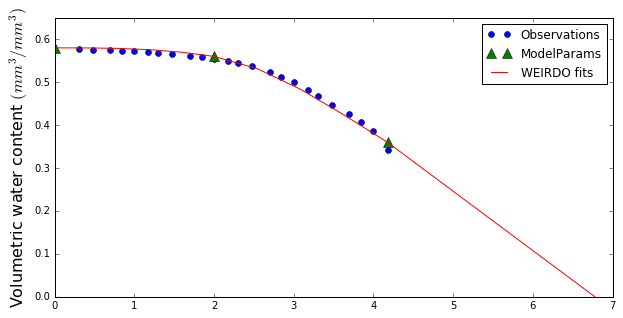

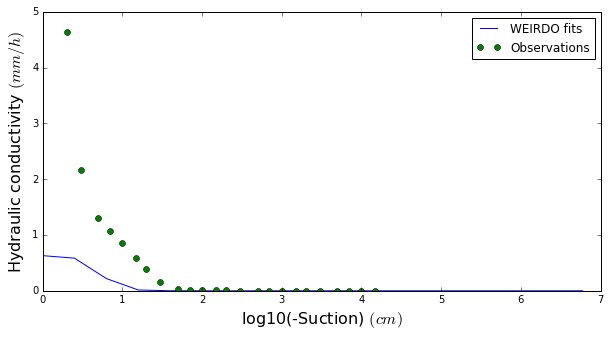

In [14]:
Set = '4681'
FitSAT = 0.58
FitDUL = 0.56
FitLL = 0.36

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(FullData.ix[Set,'preshead']),FullData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([1,100,15000]),[FitSAT,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurve(FitSAT,FitDUL,FitLL,BoundPSI),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL)

ymax = 10
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(FullData.ix[Set,'preshead']),FullData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(cm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.legend()

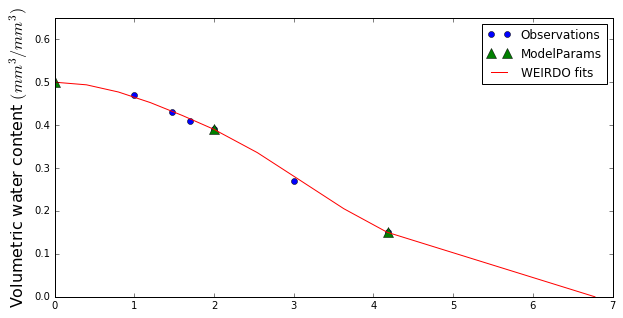

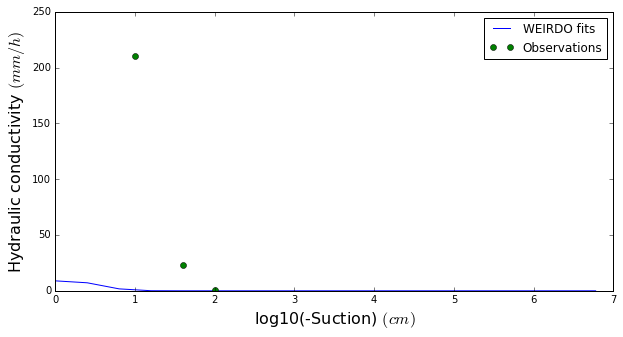

In [15]:
AblockPsi = [0,10,30,50,100,1000,15000]
AblockTheta = [0.55,.47,.43,.41,.39,.27,.15]
AblockPsi2 = [10, 40, 100]
AblockK = [210,23,1]

FitSAT = 0.50
FitDUL = 0.39
FitLL = 0.15

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(AblockPsi),AblockTheta,'o',label = 'Observations')
plt.plot(np.log10([1,100,15000]),[FitSAT,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurve(FitSAT,FitDUL,FitLL,BoundPSI),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL)

ymax = 10
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(AblockPsi2),AblockK,'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(cm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.legend()